# Two moons example

In [12]:
import os

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jaxili.inference import NPE, NLE

import numpyro.distributions as dist

from getdist import plots, MCSamples
%matplotlib inline

print("Device used by jax:", jax.devices())

Device used by jax: [cuda(id=0)]


Two moons is a standard benchmark task where the posterior is bimodal. This is a good example to test the ability of NPE and NLE to sample from a complex posterior.

## Defining the simulator

We will try to solve the following inference problem:

- Prior: $\mathcal{U}(-1, 1)$
- Simulator: $x|\theta \sim \left[\begin{array}{c} r\cos(\alpha)+0.25 \\ r\sin(\alpha)\end{array}\right]+\left[ \begin{array}{c} -|\theta_1+\theta_2|/\sqrt{2}\\ (-\theta_1+\theta_2)/\sqrt{2} \end{array}\right]$ where $\alpha \sim \mathcal{U}(-\pi/2, \pi/2)$ and $r \sim \mathcal{N}(0.1, 0.01^2)$
- $\theta \in \mathbb{R}^2$, $x\in \mathbb{R}^2$

Let's implement the simulator.

In [2]:
def simulator(theta, rng_key):
    batch_size = theta.shape[0]

    #Sample angle
    alpha_key, rng_key = jax.random.split(rng_key)
    alpha = jax.random.uniform(alpha_key, (batch_size, 1), minval=-jnp.pi/2, maxval=jnp.pi/2)

    #Sample radius
    r_key, rng_key = jax.random.split(rng_key)
    r = jax.random.normal(r_key, (batch_size, 1))*0.01+0.1

    #Compute x_1 and x_2
    x_1 = r * jnp.cos(alpha)+0.25 - jnp.abs(theta[:, 0]+theta[:, 1]).reshape((-1, 1))/jnp.sqrt(2)
    x_2 = r * jnp.sin(alpha) + (- theta[:, 0]+theta[:, 1]).reshape((-1, 1))/jnp.sqrt(2)
    return jnp.column_stack([x_1, x_2])

Let's create the datatset.

In [3]:
master_key = jax.random.PRNGKey(0)

n_dim = 2
num_samples = 10_000
#Generate parameters
theta_key, master_key = jax.random.split(master_key)
theta = jax.random.uniform(theta_key, (num_samples, n_dim), minval=-1, maxval=1)

#Generate data
data_key, master_key = jax.random.split(master_key)
x = simulator(theta, data_key)

In [4]:
#Let's create a fiducial target
fiducial = jnp.array([[0.2, -0.5]])
obs = simulator(fiducial, jax.random.PRNGKey(0))

print("Fiducial parameters:", fiducial)
print("Fiducial observation:", obs)

Fiducial parameters: [[ 0.2 -0.5]]
Fiducial observation: [[ 0.15164769 -0.47430325]]


## Neural Posterior Estimation (NPE)

Let's setup the pipeline. We create the inference object, we push the simulations, we train and we fetch the posterior!

In [5]:
inference = NPE()
inference = inference.append_simulations(np.array(theta), np.array(x))

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.


[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.


In [6]:
#Specify a checkpoint to save the weights of the neural network
CHECKPOINT_PATH = "."
#Turn it into an absolut path
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

num_epochs = 500

metrics, density_estimator = inference.train(
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=num_epochs,
)

[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epochs: Val loss -0.695/ Best val loss -0.695:   0%|          | 1/500 [00:13<1:53:48, 13.68s/it]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_for

Neural network training stopped after 206 epochs.
Early stopping with best validation metric: -3.3453128337860107
Best model saved at epoch 185
Early stopping parameters: min_delta=0.001, patience=20


[!] Training loss: -3.4060730934143066
[!] Validation loss: -3.3453128337860107
[!] Test loss: -3.3304574489593506


In [7]:
posterior = inference.build_posterior()

[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


## Checking the posterior

In [8]:
sample_key, master_key = jax.random.split(master_key)
samples = posterior.sample(x=obs, num_samples=10_000, key=sample_key) 

Removed no burn in


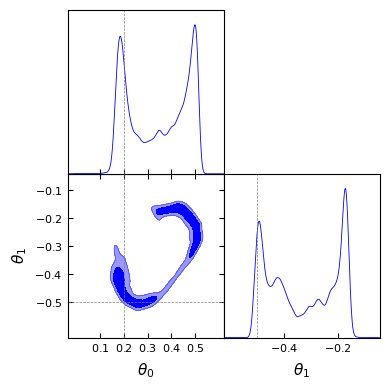

In [9]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

## Neural Likelihood Estimation (NLE)

Likewise, we can learn the likelihood before sampling the posterior.

In [10]:
inference = NLE()
inference = inference.append_simulations(np.array(theta), np.array(x))

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.


In [11]:
#Specify a checkpoint to save the weights of the neural network
CHECKPOINT_PATH = "."
#Turn it into an absolut path
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

num_epochs = 500

metrics, density_estimator = inference.train(
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=num_epochs,
)

[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epochs: Val loss -1.028/ Best val loss -1.028:   0%|          | 1/500 [00:09<1:18:17,  9.41s/it]/home/sacha/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_for

Neural network training stopped after 129 epochs.
Early stopping with best validation metric: -4.2458930015563965
Best model saved at epoch 108
Early stopping parameters: min_delta=0.001, patience=20


[!] Training loss: -4.239800453186035
[!] Validation loss: -4.2458930015563965
[!] Test loss: -4.2225518226623535


In [15]:
posterior = inference.build_posterior(
    prior_distr=dist.Uniform(low=jnp.array([-1, -1]), high=jnp.array([1, 1])),
    mcmc_kwargs={'num_chains': 10}
)

Using MCMC method: nuts_numpyro
MCMC kwargs: {'num_chains': 10}
[!] Posterior $p(\theta| x)$ built. The class MCMCPosterior is used to sample and evaluate the log probability.\n The sampling is performed using MCMC methods.


In [16]:
num_samples = 2_500
sample_key, master_key = jax.random.split(master_key)
samples_nle = posterior.sample(
    x=obs, num_samples=num_samples, key=sample_key
)

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/jaxili/posterior/mcmc_posterior.py:243: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:29<00:00, 100.09it/s, 13 steps of size 1.40e-01. acc. prob=0.94]


Removed no burn in
Removed no burn in


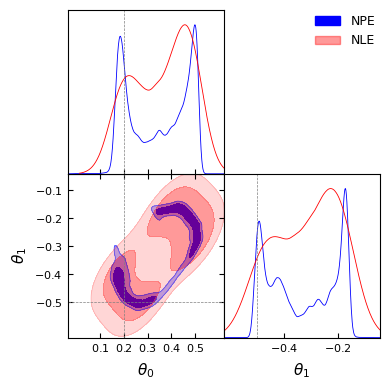

In [17]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples, names=labels, labels=labels)
samples_nle_gd = MCSamples(samples=samples_nle, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd, samples_nle_gd], filled=True,
                line_args=[
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                legend_labels=['NPE', 'NLE'],
                contour_colors=['blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()